In [1]:
#Import Required Libraries
import requests
import math
import pandas as pd
import numpy as np
from numpy import array

from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Input

import matplotlib.pyplot as plt

In [2]:
API_KEY = "66842ac2b00f870d7ee9a1ddae886503969a694c"
ticker = 'TSLA'
end_date = datetime.today().strftime("%Y-%m-%d")
start_date = (datetime.today() - timedelta(days=5*365)).strftime("%Y-%m-%d")

In [3]:
url = f"https://api.tiingo.com/tiingo/daily/{ticker}/prices?startDate={start_date}&endDate={end_date}&token={API_KEY}"

In [4]:
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)
df

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,2020-03-24T00:00:00.000Z,505.00,513.69,474.0000,477.300,22895170,33.666667,34.246000,31.600000,31.820000,343427550,0.0,1.0
1,2020-03-25T00:00:00.000Z,539.25,557.00,511.1100,545.250,21222745,35.950000,37.133333,34.074000,36.350000,318341175,0.0,1.0
2,2020-03-26T00:00:00.000Z,528.16,560.00,512.2500,547.390,17422082,35.210667,37.333333,34.150000,36.492667,261331230,0.0,1.0
3,2020-03-27T00:00:00.000Z,514.36,525.80,494.0300,505.000,14377408,34.290667,35.053333,32.935333,33.666667,215661120,0.0,1.0
4,2020-03-30T00:00:00.000Z,502.13,516.65,491.2300,510.260,11998067,33.475333,34.443333,32.748667,34.017333,179971005,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1251,2025-03-17T00:00:00.000Z,238.01,245.40,232.8000,245.055,111900565,238.010000,245.400000,232.800000,245.055000,111900565,0.0,1.0
1252,2025-03-18T00:00:00.000Z,225.31,230.10,222.2800,228.155,111477636,225.310000,230.100000,222.280000,228.155000,111477636,0.0,1.0
1253,2025-03-19T00:00:00.000Z,235.86,241.41,229.2010,231.610,111993753,235.860000,241.410000,229.201000,231.610000,111993753,0.0,1.0
1254,2025-03-20T00:00:00.000Z,236.26,238.00,230.0501,233.345,99028270,236.260000,238.000000,230.050100,233.345000,99028270,0.0,1.0


In [5]:
latest_df = df.iloc[-1]
latest_df

date           2025-03-21T00:00:00.000Z
close                            248.71
high                             249.52
low                              234.55
open                            234.985
volume                        132728684
adjClose                         248.71
adjHigh                          249.52
adjLow                           234.55
adjOpen                         234.985
adjVolume                     132728684
divCash                             0.0
splitFactor                         1.0
Name: 1255, dtype: object

In [6]:
float(latest_df['adjClose'])

248.71

In [7]:
df_close = df.reset_index()['adjClose']
df_close

0        33.666667
1        35.950000
2        35.210667
3        34.290667
4        33.475333
           ...    
1251    238.010000
1252    225.310000
1253    235.860000
1254    236.260000
1255    248.710000
Name: adjClose, Length: 1256, dtype: float64

 ## Model #1 - Stacked LTSM with adjusted closing price


In [8]:
#Reshape Close columns data between 0-1 (LSTM models are sensitive to the scale of data)
scaler = MinMaxScaler(feature_range=(0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1)) #Convert into array with values 0-1
df_close

array([[0.00749322],
       [0.01257224],
       [0.01092767],
       ...,
       [0.4572495 ],
       [0.45813926],
       [0.48583288]])

In [9]:
#Split dataset into Train and Test
training_size = int(len(df_close)*0.65)
testing_size = len(df_close)-training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [10]:
training_size, testing_size

(816, 440)

In [11]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step,0])
    return np.array(dataX), np.array(dataY)

In [12]:
time_step = 100
Xtrain, Ytrain = create_dataset(train_data, time_step)
Xtest, Ytest = create_dataset(test_data, time_step)
Xtrain, Ytrain

(array([[0.00749322, 0.01257224, 0.01092767, ..., 0.13641722, 0.16316474,
         0.17298763],
        [0.01257224, 0.01092767, 0.00888124, ..., 0.16316474, 0.17298763,
         0.1773934 ],
        [0.01092767, 0.00888124, 0.00706762, ..., 0.17298763, 0.1773934 ,
         0.20481713],
        ...,
        [0.22938327, 0.25236119, 0.2526726 , ..., 0.47624577, 0.48832419,
         0.50807675],
        [0.25236119, 0.2526726 , 0.25387377, ..., 0.48832419, 0.50807675,
         0.50380593],
        [0.2526726 , 0.25387377, 0.28910807, ..., 0.50807675, 0.50380593,
         0.50182622]]),
 array([0.1773934 , 0.20481713, 0.21244678, 0.2111774 , 0.22946186,
        0.23660214, 0.23129624, 0.23265163, 0.25190445, 0.26459532,
        0.2608361 , 0.30209107, 0.28483724, 0.26431356, 0.23438072,
        0.24277408, 0.17744382, 0.20418837, 0.20794017, 0.20896339,
        0.24373798, 0.26608566, 0.26015396, 0.24656295, 0.26044313,
        0.26581132, 0.24715612, 0.21462816, 0.22013723, 0.23463282,
 

In [13]:
#Create the Stacked LSTM Model
Xtrain =Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1] , 1)
Xtest = Xtest.reshape(Xtest.shape[0],Xtest.shape[1] , 1)



In [14]:
model_1 = Sequential([
    Input(shape=(100, 1)),  # Explicit Input Layer
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(1)
])
model_1.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_1.fit(Xtrain,Ytrain,validation_data=(Xtest,Ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - loss: 0.0972 - val_loss: 0.0258
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0146 - val_loss: 0.0122
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0082 - val_loss: 0.0091
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0059 - val_loss: 0.0086
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0054 - val_loss: 0.0068
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3

In [17]:

train_predict = model_1.predict(Xtrain)
test_predict = model_1.predict(Xtest)

##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

Ytrain_inv = scaler.inverse_transform(Ytrain.reshape(-1, 1))
Ytest_inv = scaler.inverse_transform(Ytest.reshape(-1, 1))

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [18]:
### Calculate RMSE performance metrics

rmse_train = math.sqrt(mean_squared_error(Ytrain_inv, train_predict))
rmse_test = math.sqrt(mean_squared_error(Ytest_inv, test_predict))
mean_price_train = np.mean(Ytrain_inv)
mean_price_test = np.mean(Ytest_inv)
nrmse_train = (rmse_train / mean_price_train) * 100
nrmse_test = (rmse_test / mean_price_test) * 100
rmse_train, rmse_test, nrmse_train, nrmse_test

(16.981773385727816,
 19.720469549309342,
 np.float64(7.231984718371795),
 np.float64(7.914300810113496))

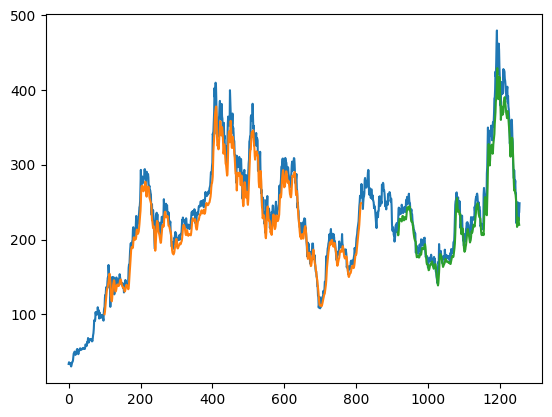

In [19]:
### Plotting 

# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_close)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [20]:
len(test_data)

440

In [21]:
x_input=test_data[len(test_data)-100:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [22]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        print(x_input)
        yhat = model_1.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_1.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
        

[0.43451828]
101
[0.5313883290847536, 0.5165294219707182, 0.5098785039660825, 0.5054964609998176, 0.48836867884741153, 0.4864334619029188, 0.4727757239268444, 0.4919054546425188, 0.5744079793220956, 0.5930483448334157, 0.6471231999145836, 0.7111410661933171, 0.663294495531206, 0.6671871732931165, 0.62479035149768, 0.6460110062683234, 0.6860944652795388, 0.702243517023236, 0.6934126994719304, 0.688096413842807, 0.716835497662169, 0.6857608071856607, 0.6849600277603535, 0.6730817996182952, 0.700375031697519, 0.7269119720972858, 0.7142996961486959, 0.7287804574230029, 0.7544943745245373, 0.7983815358059624, 0.7996494365626988, 0.824562574238926, 0.877458504055058, 0.8626218408139479, 0.9029499824273405, 0.9625413179939585, 1.0, 0.9116250928681695, 0.9028165191897892, 0.8692060271998079, 0.8904266819704513, 0.9608952713974935, 0.9427665149634533, 0.8927845325005228, 0.8610870135821089, 0.8309020780226086, 0.7762711261183106, 0.8455830341532425, 0.8469399104016799, 0.8098148864895165, 0.811

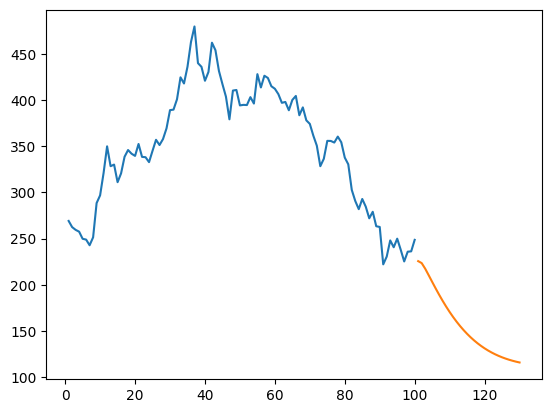

In [23]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

plt.plot(day_new,scaler.inverse_transform(df_close[1156:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

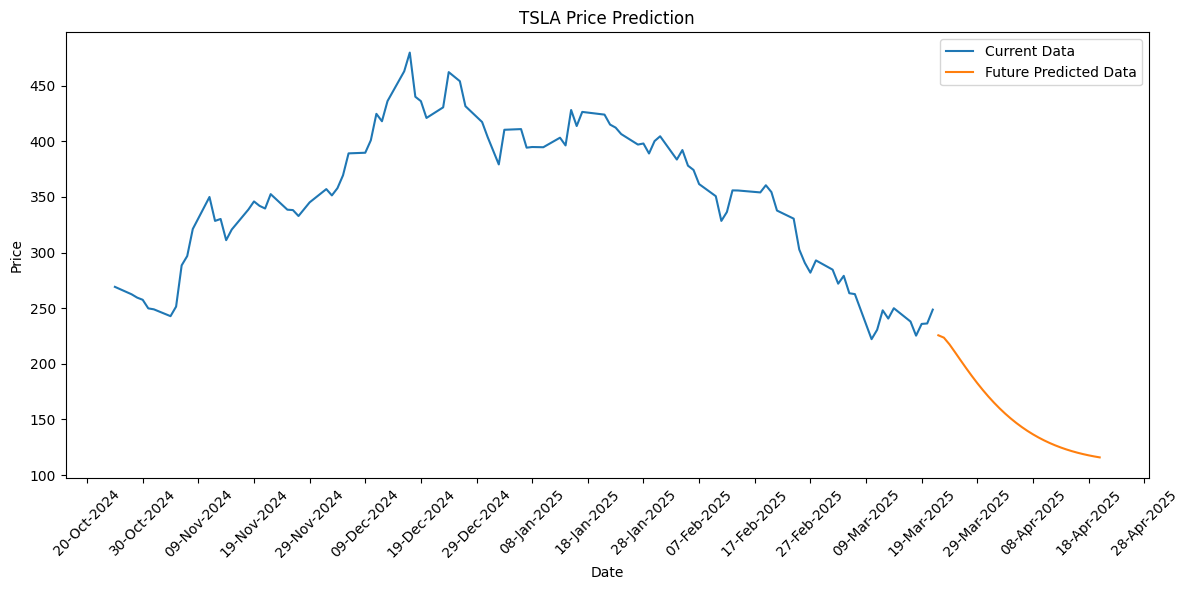

In [25]:
import matplotlib.dates as mdates

dates = pd.to_datetime(df['date'])
last_100_days_dates = dates[-100:]
predicted_dates = pd.date_range(last_100_days_dates.iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D')

# Plot the original data with dates
plt.figure(figsize=(12,6))
plt.plot(last_100_days_dates, scaler.inverse_transform(df_close[-100:]), label='Current Data')

# Plot the predicted data with dates
plt.plot(predicted_dates, scaler.inverse_transform(lst_output), label='Future Predicted Data')

# Formatting the plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'{ticker} Price Prediction')
plt.legend()

# Customize date formatting and tick frequency
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))  # Format as YYYY-MM-DD
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Show ticks every 10 days

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to make room for the rotated x-axis labels
plt.tight_layout()

# Show the plot
plt.show()